<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Updating files: 100% (149/149), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=1acbccee992844c987b177cfb7c6f1ff2ae1d343313f4b79cc139c05f08c79cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-35gwl4k4/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul


In [ ]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import math
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

print(f'{torch.__version__=}')
print(f'{device=}')

torch.__version__='2.3.0+cu121'
device='cuda'


In [ ]:
@torch.no_grad()
def test(model, test_loader):
    test_loss = 0
    for x in test_loader:
        if not isinstance(x, tuple): x = (x,)
        with torch.autocast(device_type=device, dtype=torch.float16):
            test_loss += model.loss(*x).item()
    return test_loss / len(test_loader)

def train_one_epoch(model, optimizer, loader, loss_history, scaler, lr_scheduler=None, clip=None):
    for x in loader:
        with torch.autocast(device_type=device, dtype=torch.float16):
            if not isinstance(x, tuple): x = (x,)
            loss = model.loss(*x)

        scaler.scale(loss).backward()

        if clip is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), clip)

        if lr_scheduler is not None:
            lr = lr_scheduler.step()
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loss_history.append(loss.item())

def train(model, optimizer, train_loader, test_loader, num_epochs=10, lr_scheduler=None, clip=None):
    train_loss_history = []
    test_loss_history = []

    scaler = torch.cuda.amp.GradScaler()

    initial_loss = test(model, test_loader)
    test_loss_history.append(initial_loss)
    print(f'initial loss: {initial_loss}')

    for epoch_num in range(1, num_epochs+1):
        train_one_epoch(model, optimizer, train_loader, train_loss_history, scaler,
                        lr_scheduler=lr_scheduler, clip=clip)

        test_loss = test(model, test_loader)
        test_loss_history.append(test_loss)

        print(f'epoch {epoch_num}: {test_loss}')

    return train_loss_history, test_loss_history

def create_dataloaders(train_data, test_data, batch_size):
    train_loader = DataLoader(train_data, batch_size, shuffle=True, generator=torch.Generator(device=device),)
    test_loader = DataLoader(test_data, batch_size, generator=torch.Generator(device=device))
    return train_loader, test_loader

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


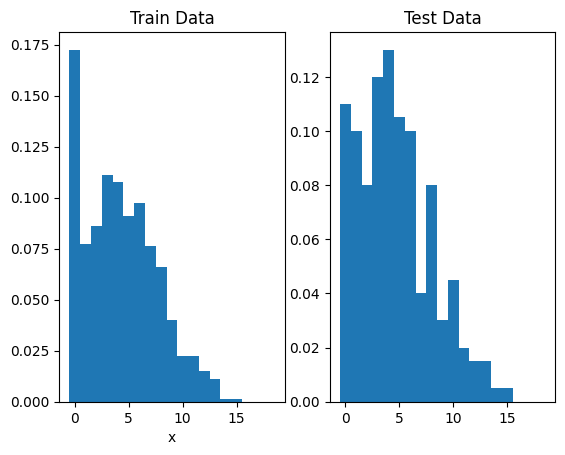

Dataset 2


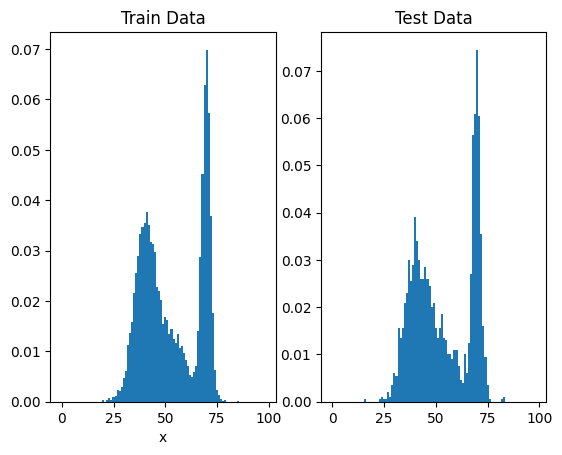

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(1, 'a', q1_a)

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(1, 'b', q1_b)

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

In [ ]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [ ]:
q2a_save_results(1, q2_a)

In [ ]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2b_save_results(1, 'b', q2_b)

In [ ]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1, attn_mask=None, is_causal=False):
        super().__init__()
        self.key = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

        self.is_causal = is_causal
        self.attn_mask = attn_mask
        self.num_heads = num_heads
        self.scaling_factor = math.sqrt(d_model / num_heads)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        N, S, D = query.shape
        N, T, D = value.shape
        H = self.num_heads

        # (N, S, D) @ (D, D) -> (N, S, D) -> (N, S, H, D/H) -> (N, H, S, D/H)
        Q = self.query(query).view(N, S, H, D//H).transpose(1, 2)
        # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
        K = self.key(key).view(N, T, H, D//H).transpose(1, 2)
        # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
        V = self.value(value).view(N, T, H, D//H).transpose(1, 2)

        # (N, H, S, D/H) @ (N, H, D/H, T) -> (N, H, S, T)
        Y = torch.matmul(Q, K.transpose(2, 3)) / self.scaling_factor

        if self.is_causal:
            self.attn_mask = torch.tril(torch.ones(S, T))

        # We apply value -inf so that softmax for that element equals 0
        if self.attn_mask is not None:
            Y = Y.masked_fill(self.attn_mask==0, float("-inf"))

        # (N, H, S, T) @ (N, H, T, D/H) -> (N, H, S, D/H)
        Y = self.dropout(F.softmax(Y, dim=-1)) @ V
        # (N, S, H, D/H) -> (N, S, D) @ (D, D) -> (N, S, D)
        out = self.proj(Y.transpose(1, 2).reshape(N, S, D))
        return out


class Block(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.causal_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout, attn_mask=attn_mask, is_causal=is_causal)
        self.msa = lambda x: self.causal_attn(x, x, x)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(nn.Linear(d_model, d_mlp), act, nn.Linear(d_mlp, d_model))

    def forward(self, x):
        x = x + self.msa(self.ln1(x))
        out = x + self.mlp(self.ln2(x))
        return out


class Transformer(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_layers=2, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.n_tokens = n_tokens
        self.max_seq_len = max_seq_len

        self.emb = nn.Embedding(n_tokens, d_model)
        self.emb.weight.data *= 0.1  # small weight initialization

        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, d_model) * 0.1)

        self.blocks = nn.Sequential(*[
            Block(d_model, n_heads, d_mlp, dropout, act, attn_mask, is_causal) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_tokens-1)  # we don't want net to predict <bos>; hence the -1

    def forward(self, x):
        _, seq_len = x.shape

        x = self.emb(x) + self.pos_enc[:seq_len, :] # (N, T, D)
        x = self.blocks(x)
        logits = self.head(self.ln(x))
        return logits

    def loss(self, y):  # (N, T)
        # since autoregressive transformer always predicts the next token for all my NNs,
        # x will get created on the fly by prepending <bos> (token id: 2) and removing the last token in the seq.
        # I could create separate x and y before hand, but this means I can't reuse my train functions

        N, _ = y.shape
        x = torch.cat((torch.tensor(self.n_tokens-1).expand(N, 1), y[:, :-1]), dim=-1)

        logits = self.forward(x)
        return F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))

    def generate(self, n_samples: int):
        x = torch.zeros((n_samples, self.max_seq_len), dtype=torch.long)
        x[:, 0] = self.n_tokens-1 # add <bos> token
        for i in range(self.max_seq_len):
            logits = self.forward(x)  # (N, T, n_token-1)
            prob_dist = torch.softmax(logits[:, i, :], dim=-1)  # (N, n_token-1)
            samples = torch.multinomial(prob_dist, num_samples=1)  # (N, 1)

            if i == self.max_seq_len-1:
                return torch.cat((x[:, 1:], samples), dim=1)

            x[:, i+1] = samples.view(-1)

In [ ]:
class CosineScheduler:
    def __init__(self, warmup_iters, lr_decay_iters, base_lr, min_lr):
        self.warmup_iters = warmup_iters
        self.lr_decay_iters = lr_decay_iters
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.iter = 0
    def step(self):
        if self.iter < self.warmup_iters:
            lr = self.base_lr * self.iter / self.warmup_iters
        else:
            iter = self.iter - self.warmup_iters
            lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) \
                * (1 + math.cos(math.pi * iter / self.lr_decay_iters))
        self.iter += 1
        return lr

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  n_train, H, W, _ = train_data.shape
  n_test = test_data.shape[0]

  train_data = train_data.reshape(n_train, -1)
  test_data = test_data.reshape(n_test, -1)

  hyp = dict(
    lr=1e-3,
    epochs=15,
    batch_size=32,
    warmup_iters=1000,
    min_lr=1e-4,
    dropout=0.0,
    n_tokens=3,
  )

  hyp['lr_decay_iters'] = (n_train // hyp['batch_size']) * hyp['epochs'] - hyp['warmup_iters']

  lr_scheduler = CosineScheduler(warmup_iters=hyp['warmup_iters'], lr_decay_iters=hyp['lr_decay_iters'],
                                 base_lr=hyp['lr'], min_lr=hyp['min_lr'])

  model = Transformer(n_tokens=hyp['n_tokens'], max_seq_len=H*W, n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])

  optimizer = optim.Adam(model.parameters(), lr=hyp['lr'])

  train_loader, test_loader = create_dataloaders(train_data, test_data, hyp['batch_size'])

  train_loss_history, test_loss_history = train(model, optimizer, train_loader, test_loader, num_epochs=hyp['epochs'],
                                                lr_scheduler=lr_scheduler, clip=1.0)


  return np.array(train_loss_history), np.array(test_loss_history), np.array(model.generate(100).cpu().view(-1, H, W, 1))

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Mon May 27 23:45:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |    419MiB / 15360MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

initial loss: 0.663876529703749
epoch 1: 0.08663107845800143
epoch 2: 0.05919856480355804
epoch 3: 0.048364150872889984
epoch 4: 0.04302956964424316
epoch 5: 0.040307899870982405
epoch 6: 0.038421291237076126
epoch 7: 0.03825361300127726
epoch 8: 0.03691999973557519
epoch 9: 0.03581227134939627
epoch 10: 0.03495196447251959
epoch 11: 0.03402860905208909
epoch 12: 0.03347018084997404
epoch 13: 0.03302199812275721
epoch 14: 0.032687208489746065
epoch 15: 0.03241729052037212
Final Test Loss: 0.0324


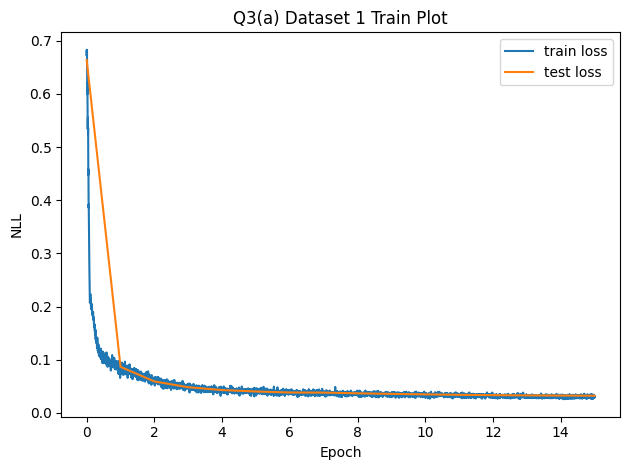

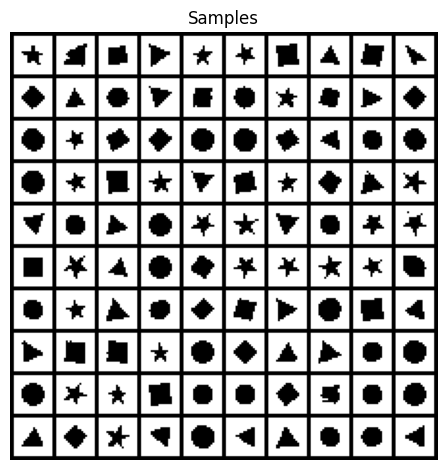

In [ ]:
q3ab_save_results(1, 'a', q3_a)

initial loss: 0.5790211049893412
epoch 1: 0.0859920771691365
epoch 2: 0.08010296640209497
epoch 3: 0.07836837107285904
epoch 4: 0.07663431663673145
epoch 5: 0.07535766576901792
epoch 6: 0.07497842296862754
epoch 7: 0.07398317094904165
epoch 8: 0.0733301515777271
epoch 9: 0.0727904345185612
epoch 10: 0.07250396365793749
epoch 11: 0.0722764389583478
epoch 12: 0.0719974599183558
epoch 13: 0.07185246033695178
epoch 14: 0.07178543212886054
epoch 15: 0.07187893740332926
Final Test Loss: 0.0719


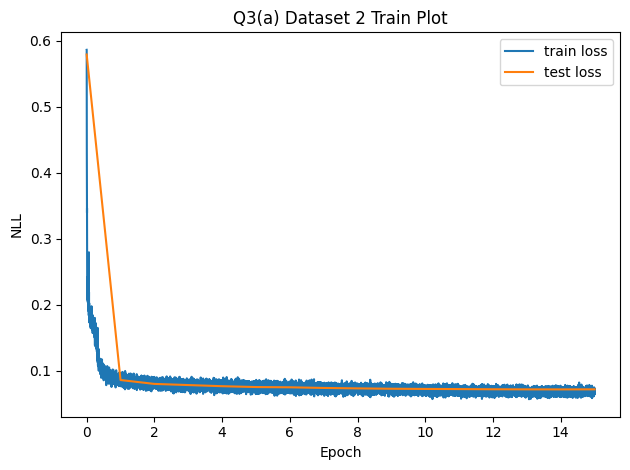

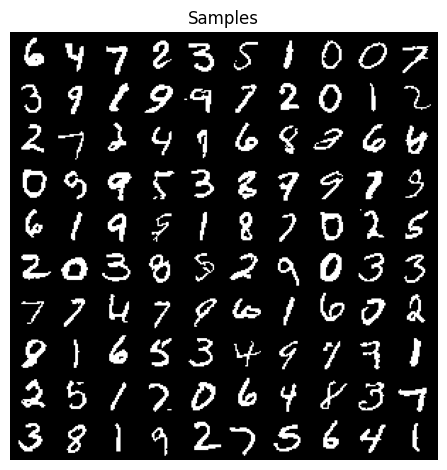

In [ ]:
torch.cuda.empty_cache()
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def base_to_tokens(x: np.ndarray, base=4, channels=3):
    B = x.shape[0]
    f = base ** np.arange(0, channels)[::-1]
    return np.sum(x * f, axis=-1)

def token_to_base(x: np.ndarray, base=4, n_channels=3):
    factors = np.array([base**i for i in reversed(range(n_channels))])
    out = (x[..., np.newaxis] // factors) % base
    return out

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  n_train, H, W, _ = train_data.shape
  n_test = test_data.shape[0]

  # preprocess data to be in correct format
  train_data = base_to_tokens(train_data)  # -> (n_train, H, W)
  train_data = train_data.reshape(n_train, -1)

  test_data = base_to_tokens(test_data)  # -> (n_train, H, W)
  test_data = test_data.reshape(n_test, -1)

  hyp = dict(
    lr=1e-3,
    epochs=15,
    batch_size=32,
    warmup_iters=0,
    min_lr=1e-4,
    dropout=0.0,
  )

  hyp['lr_decay_iters'] = (n_train // hyp['batch_size']) * hyp['epochs'] - hyp['warmup_iters']

  lr_scheduler = CosineScheduler(warmup_iters=hyp['warmup_iters'], lr_decay_iters=hyp['lr_decay_iters'],
                                 base_lr=hyp['lr'], min_lr=hyp['min_lr'])

  model = Transformer(n_tokens=65, max_seq_len=H*W, n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])

  optimizer = optim.Adam(model.parameters(), lr=hyp['lr'])

  train_loader, test_loader = create_dataloaders(train_data, test_data, hyp['batch_size'])

  train_loss_history, test_loss_history = train(model, optimizer, train_loader, test_loader, num_epochs=hyp['epochs'],
                                                lr_scheduler=lr_scheduler, clip=1.0)

  torch.save(model.state_dict(), 'model.pt')

  return np.array(train_loss_history), np.array(test_loss_history), np.array(token_to_base(model.generate(100).cpu().view(-1, H, W)))

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

initial loss: 4.414398203504846
epoch 1: 0.1357584686038342
epoch 2: 0.10457521872528901
epoch 3: 0.08442927035668217
epoch 4: 0.07395643289101884
epoch 5: 0.06673957629406706
epoch 6: 0.06197274037709473
epoch 7: 0.058741701198807846
epoch 8: 0.05676351862807646
epoch 9: 0.056077477753373746
epoch 10: 0.05396913504558252
epoch 11: 0.052958889078375294
epoch 12: 0.052218909514077164
epoch 13: 0.051574523382364436
epoch 14: 0.05114091621011707
epoch 15: 0.05082830987500806
Final Test Loss: 0.0508


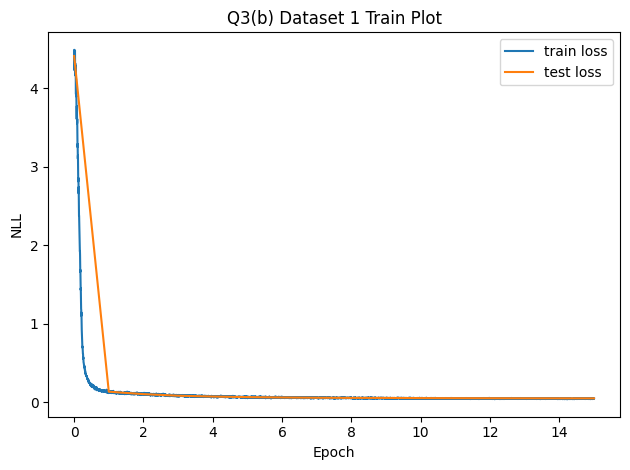

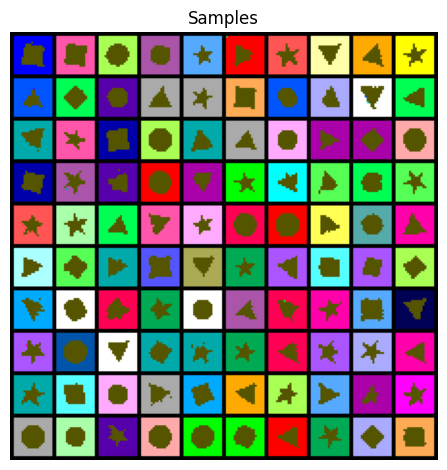

In [ ]:
torch.cuda.empty_cache()
q3ab_save_results(1, 'b', q3_b)

initial loss: 4.635206361167347
epoch 1: 0.2619005460708667
epoch 2: 0.13891096965383037
epoch 3: 0.11476016963442294
epoch 4: 0.10628114455043318
epoch 5: 0.10207037884777727
epoch 6: 0.0980927749230458
epoch 7: 0.09631795221909928
epoch 8: 0.09403131526118269
epoch 9: 0.09217041569015089
epoch 10: 0.09094416988067353
epoch 11: 0.08952299693521981
epoch 12: 0.08855509450926949
epoch 13: 0.08756993782406036
epoch 14: 0.08725857546630378
epoch 15: 0.08690572268189714
Final Test Loss: 0.0869


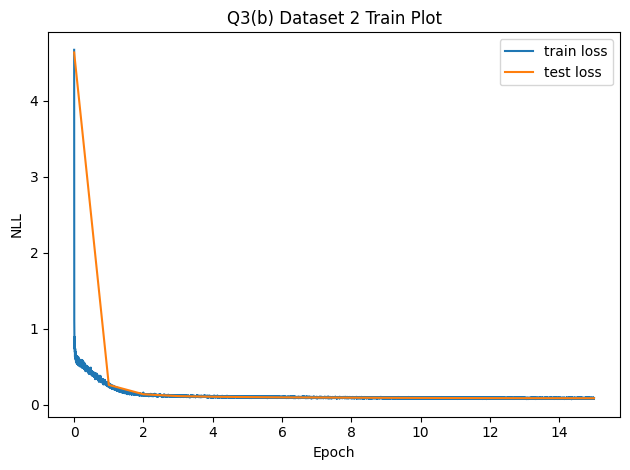

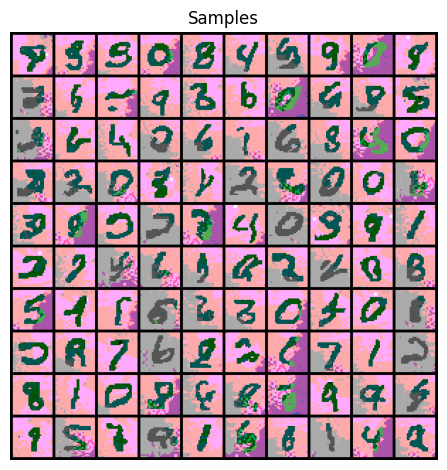

In [ ]:
torch.cuda.empty_cache()
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, attn_mask=None, is_causal=False):
        super().__init__()
        self.key = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

        self.is_causal = is_causal
        self.attn_mask = attn_mask
        self.n_heads = n_heads
        self.scaling_factor = math.sqrt(d_model / n_heads)
        self.dropout = nn.Dropout(dropout)

        self.KV_cache = None

    def forward_kv_cache(self, query, key, value):
        N, D = query.shape
        H = self.n_heads
        # (N, D) @ (D, D) -> (N, D) -> (N, H, D//H)
        Q = self.query(query).view(N, H, 1, D//H)
        K = self.key(key).view(N, H, D//H, 1)
        V = self.value(value).view(N, H, 1, D//H)

        if self.KV_cache is not None:  # append to KV cache
            self.KV_cache['keys'] = torch.cat([self.KV_cache['keys'], K.view(N, H, D//H, 1)], dim=-1)
            self.KV_cache['values'] = torch.cat([self.KV_cache['values'], V.view(N, H, 1, D//H)], dim=-2)
        else:  # init KV cache
            self.KV_cache = {'keys': K, 'values': V}  # keys: (N, H, D//H, S); values: (N, H, S, D//H)

        Y = (Q @ self.KV_cache['keys']) / self.scaling_factor   # (N, H, 1, D//H) @ (N, H, D//H, S) -> (N, H, 1, S)

        Y = self.dropout(F.softmax(Y, dim=-1)) @ self.KV_cache['values']  # (N, H, 1, S) @ (N, H, S, D//H)
        out = self.proj(Y.view(N, D))
        return out

    def forward(self, query, key, value):
        if self.training:
            N, S, D = query.shape
            N, T, D = value.shape
            H = self.n_heads

            # (N, S, D) @ (D, D) -> (N, S, D) -> (N, S, H, D/H) -> (N, H, S, D/H)
            Q = self.query(query).view(N, S, H, D//H).transpose(1, 2)
            # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
            K = self.key(key).view(N, T, H, D//H).transpose(1, 2)
            # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
            V = self.value(value).view(N, T, H, D//H).transpose(1, 2)

            # (N, H, S, D/H) @ (N, H, D/H, T) -> (N, H, S, T)
            Y = torch.matmul(Q, K.transpose(2, 3)) / self.scaling_factor

            if self.is_causal:
                self.attn_mask = torch.tril(torch.ones(S, T))

            # We apply value -inf so that softmax for that element equals 0
            if self.attn_mask is not None:
                Y = Y.masked_fill(self.attn_mask==0, float("-inf"))

            # (N, H, S, T) @ (N, H, T, D/H) -> (N, H, S, D/H)
            Y = self.dropout(F.softmax(Y, dim=-1)) @ V
            # (N, S, H, D/H) -> (N, S, D) @ (D, D) -> (N, S, D)
            out = self.proj(Y.transpose(1, 2).reshape(N, S, D))
        else:
            out = self.forward_kv_cache(query, key, value)

        return out


class Block(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.causal_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout, attn_mask=attn_mask, is_causal=is_causal)
        self.msa = lambda x: self.causal_attn(x, x, x)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(nn.Linear(d_model, d_mlp), act, nn.Linear(d_mlp, d_model))

    def forward(self, x):
        x = x + self.msa(self.ln1(x))
        out = x + self.mlp(self.ln2(x))
        return out


class Transformer(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_layers=2, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.n_tokens = n_tokens
        self.max_seq_len = max_seq_len

        self.emb = nn.Embedding(n_tokens, d_model)
        self.emb.weight.data *= 0.01  # small weight initialization

        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, d_model) * 0.01)

        self.blocks = nn.Sequential(*[
            Block(d_model, n_heads, d_mlp, dropout, act, attn_mask, is_causal) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_tokens-1)  # we don't want net to predict <bos>; hence the -1
        self.pos = 0  # used for KV cache

    def forward(self, x):
        if self.training:  # x: (B, S)
            _, seq_len = x.shape
            pos_enc = self.pos_enc[:seq_len, :] # (B, S, D)
        else:  # x: (B, ) (we use KV cache in this case)
            pos_enc = self.pos_enc[self.pos, :]
            self.pos = min(self.pos + 1, self.max_seq_len - 1)

        x = self.emb(x) + pos_enc
        x = self.blocks(x)
        logits = self.head(self.ln(x))
        return logits

    def loss(self, y):  # (B, S)
        # since autoregressive transformer always predicts the next token for all my NNs,
        # x will get created on the fly by prepending <bos> (token id: 2) and removing the last token in the seq.
        # I could create separate x and y before hand, but this means I can't reuse my train functions

        N, _ = y.shape
        x = torch.cat((torch.tensor(self.n_tokens-1).expand(N, 1), y[:, :-1]), dim=-1)
        print(f'{x.shape=}')

        logits = self.forward(x)
        print(f'{logits.shape=}')
        return F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))

    @torch.no_grad()
    def generate(self, n_samples: int, use_KV_cache=True):
        self.eval() if use_KV_cache else self.train()

        x = torch.zeros((n_samples, self.max_seq_len), dtype=torch.long)
        x[:, 0] = self.n_tokens-1 # add <bos> token


        start_event = [torch.cuda.Event(enable_timing=True) for i in range(self.max_seq_len)]
        end_event = [torch.cuda.Event(enable_timing=True) for i in range(self.max_seq_len)]


        for i in range(self.max_seq_len):

            start_event[i].record()

            logits = self.forward(x[:, i] if use_KV_cache else x)
            prob_dist = torch.softmax(logits if use_KV_cache else logits[:, i, :], dim=-1)  # (N, n_token-1)
            samples = torch.multinomial(prob_dist, num_samples=1)  # (N, 1)

            if (i == self.max_seq_len - 1):
                x = torch.cat((x[:, 1:], samples), dim=1)
                end_event[i].record()
                time_list = [s.elapsed_time(e) for s, e in zip(start_event, end_event)]

                return time_list, x


            x[:, i+1] = samples.view(-1)

            end_event[i].record()


In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  n_train, H, W, C = train_data.shape

  hyp = dict(
    lr=1e-3,
    epochs=15,
    batch_size=32,
    warmup_iters=1000,
    min_lr=1e-4,
    dropout=0.0,
  )

  model = Transformer(n_tokens=65, max_seq_len=H*W, n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])

  model.load_state_dict(torch.load('model.pt'))

  time_list_no_cache, samples_no_cache = model.generate(100, use_KV_cache=False)
  time_list_no_cache = np.array(time_list_no_cache) / 1e3
  print(f'{time_list_no_cache.mean()=}')
  samples_no_cache = np.array(token_to_base(samples_no_cache.cpu().view(-1, H, W)))

  time_list_with_cache, samples_with_cache = model.generate(100, use_KV_cache=True)
  time_list_with_cache = np.array(time_list_with_cache) / 1e3
  print(f'{time_list_with_cache.mean()=}')
  samples_with_cache = np.array(token_to_base(samples_with_cache.cpu().view(-1, H, W)))

  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



28 28
time_list_no_cache.mean()=0.18451014045793185
time_list_with_cache.mean()=0.0024153581615917537


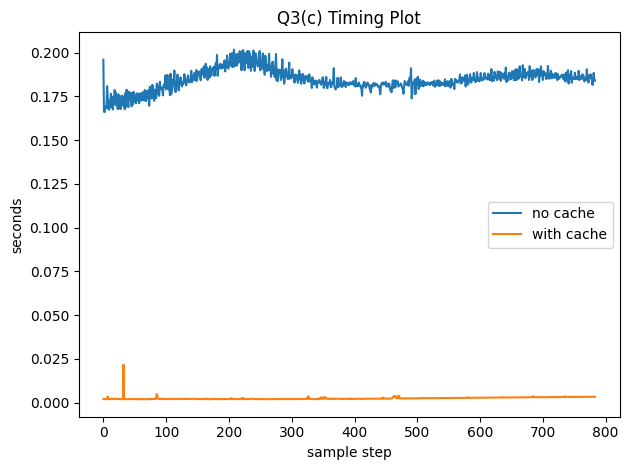

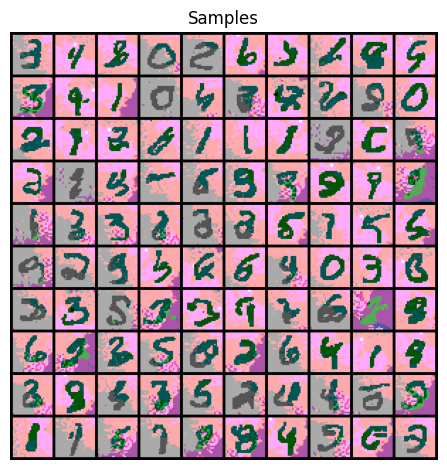

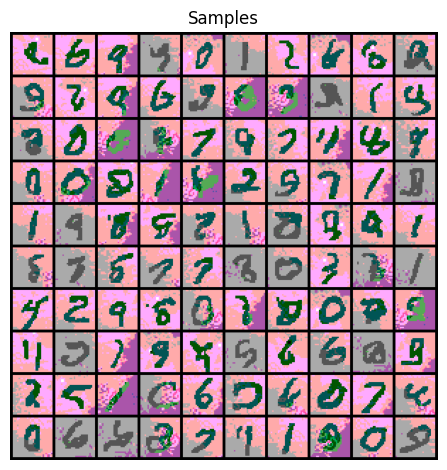

In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image.

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience.

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  print(f'{vqvae.n_embeddings=}')
  q_image = vqvae.quantize(images)  # (B, H, W, C) -> (B, 7, 7)
  autoencoded_images = vqvae.decode(q_image.cpu().numpy())  # (B, 7, 7) -> (B, H, W, C)
  print(autoencoded_images.shape)
  return autoencoded_images

vqvae.n_embeddings=1024
(2, 28, 28, 3)


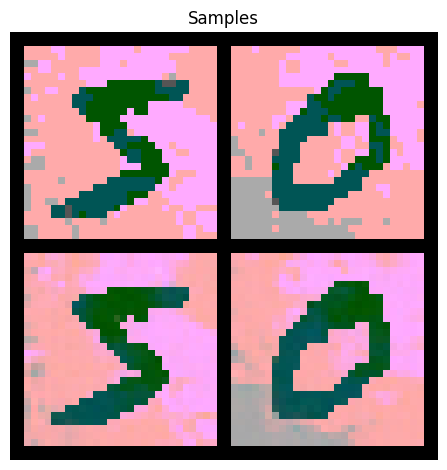

In [ ]:
q4a_save_results(1, q4_a)

vqvae.n_embeddings=1024
(2, 28, 28, 3)


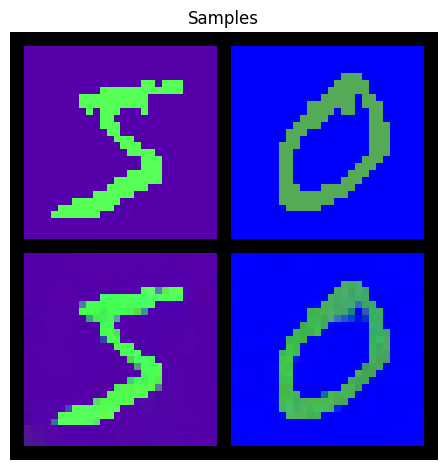

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_layers=2, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.n_tokens = n_tokens
        self.max_seq_len = max_seq_len

        self.emb = nn.Embedding(n_tokens, d_model)
        self.emb.weight.data *= 0.01  # small weight initialization

        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, d_model) * 0.01)

        self.blocks = nn.Sequential(*[
            Block(d_model, n_heads, d_mlp, dropout, act, attn_mask, is_causal) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_tokens-1)  # we don't want net to predict <bos>; hence the -1
        self.pos = 0  # used for KV cache

    def forward(self, x):
        if self.training:  # x: (B, S)
            _, seq_len = x.shape
            pos_enc = self.pos_enc[:seq_len, :] # (B, S, D)
        else:  # x: (B, ) (we use KV cache in this case)
            pos_enc = self.pos_enc[self.pos, :]
            self.pos = min(self.pos + 1, self.max_seq_len - 1)

        x = self.emb(x) + pos_enc
        x = self.blocks(x)
        logits = self.head(self.ln(x))
        return logits

    def loss(self, y):  # (B, S)
        # since autoregressive transformer always predicts the next token for all my NNs,
        # x will get created on the fly by prepending <bos> (token id: 2) and removing the last token in the seq.
        # I could create separate x and y before hand, but this means I can't reuse my train functions

        N, _ = y.shape
        x = torch.cat((torch.tensor(self.n_tokens-1).expand(N, 1), y[:, :-1]), dim=-1)
        logits = self.forward(x)

        return F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))

    @torch.no_grad()
    def generate(self, n_samples: int, use_KV_cache=True, bos_token=None):
        self.eval() if use_KV_cache else self.train()

        x = torch.zeros((n_samples, self.max_seq_len), dtype=torch.long)
        x[:, 0] = self.n_token-1 if bos_token is None else bos_token


        for i in range(self.max_seq_len):
            logits = self.forward(x[:, i] if use_KV_cache else x)
            prob_dist = torch.softmax(logits if use_KV_cache else logits[:, i, :], dim=-1)  # (N, n_token-1)
            samples = torch.multinomial(prob_dist, num_samples=1)  # (N, 1)

            if i == self.max_seq_len - 1:
                return torch.cat((x[:, 1:], samples), dim=1)

            x[:, i+1] = samples.view(-1)

In [ ]:
def tokenize_data_set(vqvae, train_data, test_data, H_t, W_t, bs=16):
    n_train, n_test = train_data.shape[0], test_data.shape[0]
    assert n_train % bs == 0 and n_test % bs == 0

    train_data_tok = np.zeros((n_train, H_t*W_t))
    test_data_tok = np.zeros((n_test, H_t*W_t))

    # tokenize data
    with torch.no_grad():
        for i in range(n_train // bs):
            train_data_tok[i*bs:(i+1)*bs] = vqvae.quantize(train_data[i*bs:(i+1)*bs]).cpu().numpy().reshape(-1, H_t*W_t)  # (n_train, H, W, C) -> (n_train, 7, 7)
            test_data_tok[i*bs:(i+1)*bs] = vqvae.quantize(test_data[i*bs:(i+1)*bs]).cpu().numpy().reshape(-1, H_t*W_t)  # (n_train, H, W, C) -> (n_train, 7, 7)

    return train_data_tok, test_data_tok

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  hyp = dict(
    lr=1e-3,
    epochs=15,
    batch_size=32,
    warmup_iters=0,
    min_lr=1e-4,
    dropout=0.0,
  )

  n_train, H, W, _ = train_data.shape
  n_test = test_data.shape[0]
  H_t, W_t = 7, 7  # tokenized shape

  train_data, test_data = tokenize_data_set(vqvae, train_data, test_data, H_t, W_t)

  train_data, test_data = train_data.astype(int), test_data.astype(int)


  hyp['lr_decay_iters'] = (n_train // hyp['batch_size']) * hyp['epochs'] - hyp['warmup_iters']

  lr_scheduler = CosineScheduler(warmup_iters=hyp['warmup_iters'], lr_decay_iters=hyp['lr_decay_iters'],
                                 base_lr=hyp['lr'], min_lr=hyp['min_lr'])

  model = Transformer(n_tokens=1025, max_seq_len=H_t*W_t, n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])

  optimizer = optim.Adam(model.parameters(), lr=hyp['lr'])

  train_loader, test_loader = create_dataloaders(train_data, test_data, hyp['batch_size'])

  train_loss_history, test_loss_history = train(model, optimizer, train_loader, test_loader, num_epochs=hyp['epochs'],
                                                lr_scheduler=lr_scheduler, clip=1.0)

  torch.save(model.state_dict(), 'model_q4.pt')

  samples = vqvae.decode(model.generate(100, use_KV_cache=True).cpu().numpy().reshape(-1, H_t, W_t))

  return np.array(train_loss_history), np.array(test_loss_history), samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
torch.cuda.empty_cache()

initial loss: 7.055630647336332
epoch 1: 3.797039858449381
epoch 2: 3.404458482425434
epoch 3: 3.2403273841443534
epoch 4: 3.1474308487706293
epoch 5: 3.0994578352370583
epoch 6: 3.0513439307959316
epoch 7: 3.017005182302798
epoch 8: 2.994650176538827
epoch 9: 2.9783835312048086
epoch 10: 2.9659765536031024
epoch 11: 2.958650387133272
epoch 12: 2.9569406715064
epoch 13: 2.953603633295614
epoch 14: 2.9585176032191267
epoch 15: 2.961346988099071
Final Test Loss: 2.9613


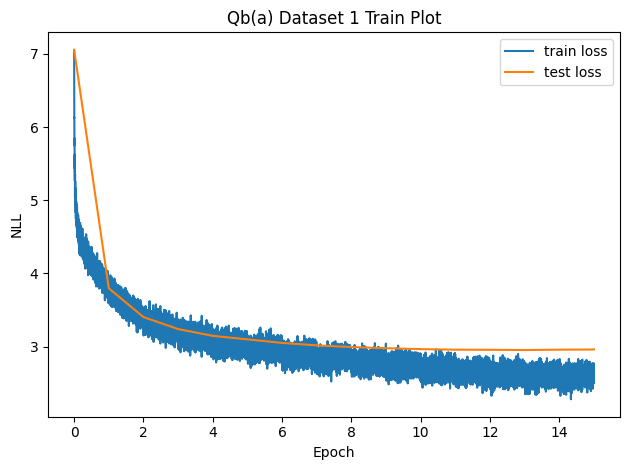

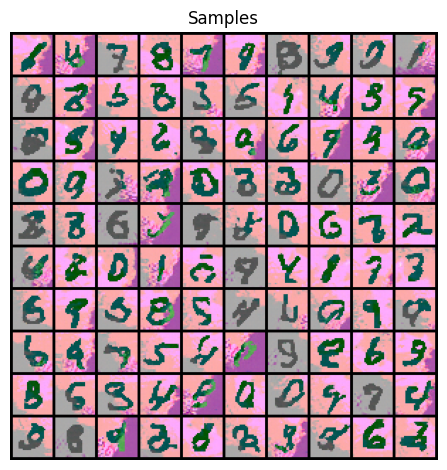

In [ ]:
q4b_save_results(1, q4_b)

initial loss: 7.119585882741422
epoch 1: 3.417554838588824
epoch 2: 3.2667274551269725
epoch 3: 3.188531626527683
epoch 4: 3.1297499600309915
epoch 5: 3.091173862877745
epoch 6: 3.0601837787384425
epoch 7: 3.0382114523135053
epoch 8: 3.0170812043138207
epoch 9: 3.0103637524687064
epoch 10: 3.000039699359443
epoch 11: 2.99805262065924
epoch 12: 2.9971214140566014
epoch 13: 2.9993175348153893
epoch 14: 3.0032892859401032
epoch 15: 3.0065659204611
Final Test Loss: 3.0066


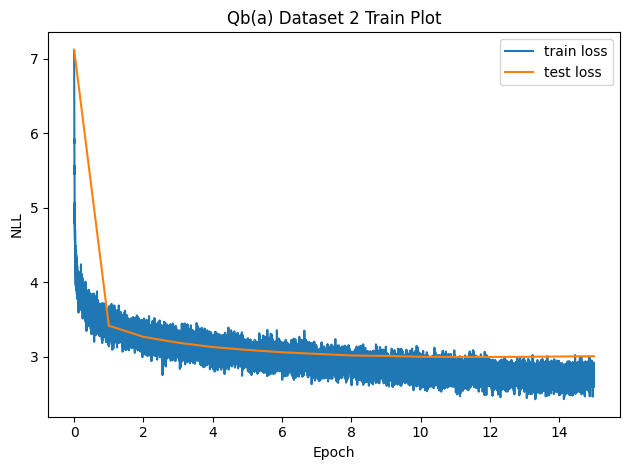

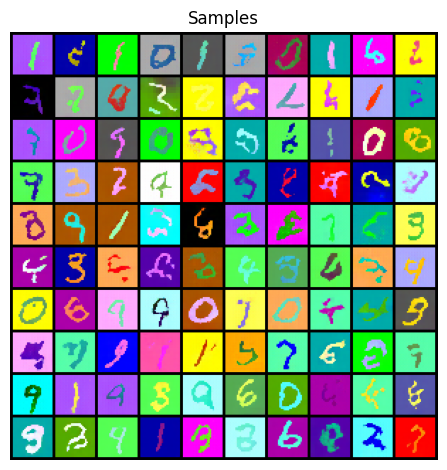

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

Sample 1
When I was fair and young, then favor graced me.
Of many was I sought their mistress for to be.
But I did scorn them all and answered them therefore:
Go, go, go, seek some other where; importune me no more.

How many weeping eyes I made to pine in woe,
How many sighing hearts I have not skill to show,
But I the prouder grew and still this spake therefore:
Go, go, go, seek some other where, importune me no more.

Then spake fair Venus son, that proud victorious boy,
Saying: You dainty dame, for that you be so coy,
I will so pluck your plumes as you shall say no more:
Go, go, go, seek some other where, importune me no more.

As soon as he had said, such change grew in my breast
That neither night nor day I could take any rest.
Wherefore I did repent that I had said before:
Go, go, go, seek some other where, importune me no more.
--------------------------------------------------------------------------------

Sample 2
The ancient songs
Pass deathward mournfully.

Cold lips that 

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
from typing import List, Tuple

class Preprocessor:
    def __init__(self, text: List[str], context_size=128):
        self.context_size = context_size

        chrs = sorted(list(set(''.join(text))))
        self.bos_idx, self.eos_idx = 0, len(chrs) + 1
        self.n_tokens = len(chrs) + 2

        self.chr_to_idx = {chr:i+1 for i, chr in enumerate(chrs)}
        self.idx_to_chr = {v:k for k,v in self.chr_to_idx.items()}
        self.idx_to_chr[0] = '<bos>'

    def preprocess(self, text: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        def passage_to_seqs(tok_passage: List[int], pad_int=0) -> np.ndarray:
            '''Splits tokenized passage into ctx length chunks. Will pad with zeros if neccessary'''
            ctx_size = self.context_size
            n_seqs = math.ceil(len(tok_passage) / ctx_size)
            return np.array([
                chunk + [pad_int] * (ctx_size - len(chunk))
                if len(chunk := tok_passage[i*ctx_size:(i+1)*ctx_size]) < ctx_size
                else chunk
                for i in range(n_seqs)
            ])

        text_tok = [
            [self.bos_idx] + [self.chr_to_idx[chr] for chr in passage] + [self.eos_idx]
            for passage in text
        ]

        X, Y = (np.zeros((0, self.context_size), dtype=int) for _ in range(2))
        for tok_passage in text_tok:
            x, y = tok_passage[:-1], tok_passage[1:]
            X, Y = np.vstack((X, passage_to_seqs(x))), np.vstack((Y, passage_to_seqs(y, pad_int=-1)))

        return X, Y

    def unpreprocess(self, data: np.ndarray) -> List[str]:
        def convert_seq(tok_seq: List[int]):
            text_seq = []
            for tok in tok_seq:
                if tok == self.eos_idx: break
                text_seq.append(self.idx_to_chr[tok])
            return ''.join(text_seq)

        return [convert_seq(seq) for seq in data.tolist()]

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, attn_mask=None, is_causal=False):
        super().__init__()
        self.key = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

        self.is_causal = is_causal
        self.attn_mask = attn_mask
        self.n_heads = n_heads
        self.scaling_factor = math.sqrt(d_model / n_heads)
        self.dropout = nn.Dropout(dropout)

        self.KV_cache = None

    def forward_kv_cache(self, query, key, value):
        N, D = query.shape
        H = self.n_heads
        # (N, D) @ (D, D) -> (N, D) -> (N, H, D//H)
        Q = self.query(query).view(N, H, 1, D//H)
        K = self.key(key).view(N, H, D//H, 1)
        V = self.value(value).view(N, H, 1, D//H)

        if self.KV_cache is not None:  # append to KV cache
            self.KV_cache['keys'] = torch.cat([self.KV_cache['keys'], K.view(N, H, D//H, 1)], dim=-1)
            self.KV_cache['values'] = torch.cat([self.KV_cache['values'], V.view(N, H, 1, D//H)], dim=-2)
        else:  # init KV cache
            self.KV_cache = {'keys': K, 'values': V}  # keys: (N, H, D//H, S); values: (N, H, S, D//H)

        Y = (Q @ self.KV_cache['keys']) / self.scaling_factor   # (N, H, 1, D//H) @ (N, H, D//H, S) -> (N, H, 1, S)

        Y = self.dropout(F.softmax(Y, dim=-1)) @ self.KV_cache['values']  # (N, H, 1, S) @ (N, H, S, D//H)
        out = self.proj(Y.view(N, D))
        return out

    def forward(self, query, key, value):
        if self.training:
            N, S, D = query.shape
            N, T, D = value.shape
            H = self.n_heads

            # (N, S, D) @ (D, D) -> (N, S, D) -> (N, S, H, D/H) -> (N, H, S, D/H)
            Q = self.query(query).view(N, S, H, D//H).transpose(1, 2)
            # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
            K = self.key(key).view(N, T, H, D//H).transpose(1, 2)
            # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
            V = self.value(value).view(N, T, H, D//H).transpose(1, 2)

            # (N, H, S, D/H) @ (N, H, D/H, T) -> (N, H, S, T)
            Y = torch.matmul(Q, K.transpose(2, 3)) / self.scaling_factor

            if self.is_causal:
                self.attn_mask = torch.tril(torch.ones(S, T))

            # We apply value -inf so that softmax for that element equals 0
            if self.attn_mask is not None:
                Y = Y.masked_fill(self.attn_mask==0, float("-inf"))

            # (N, H, S, T) @ (N, H, T, D/H) -> (N, H, S, D/H)
            Y = self.dropout(F.softmax(Y, dim=-1)) @ V
            # (N, S, H, D/H) -> (N, S, D) @ (D, D) -> (N, S, D)
            out = self.proj(Y.transpose(1, 2).reshape(N, S, D))
        else:
            out = self.forward_kv_cache(query, key, value)

        return out


class Block(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.causal_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout, attn_mask=attn_mask, is_causal=is_causal)
        self.msa = lambda x: self.causal_attn(x, x, x)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(nn.Linear(d_model, d_mlp), act, nn.Linear(d_mlp, d_model))

    def forward(self, x):
        x = x + self.msa(self.ln1(x))
        out = x + self.mlp(self.ln2(x))
        return out


class Transformer(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_layers=2, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.n_tokens = n_tokens
        self.max_seq_len = max_seq_len

        self.emb = nn.Embedding(n_tokens, d_model)
        self.emb.weight.data *= 0.01  # small weight initialization

        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, d_model) * 0.01)

        self.blocks = nn.Sequential(*[
            Block(d_model, n_heads, d_mlp, dropout, act, attn_mask, is_causal) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_tokens)
        self.pos = 0  # used for KV cache

    def forward(self, x):
        if self.training:  # x: (B, S)
            _, seq_len = x.shape
            pos_enc = self.pos_enc[:seq_len, :] # (B, S, D)
        else:  # x: (B, ) (we use KV cache in this case)
            pos_enc = self.pos_enc[self.pos, :]
            self.pos = min(self.pos + 1, self.max_seq_len - 1)

        x = self.emb(x) + pos_enc
        x = self.blocks(x)
        logits = self.head(self.ln(x))
        return logits

    def loss(self, x, y):  # (B, S)
        logits = self.forward(x)  # (B, S, T)
        return F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=-1)

    @torch.no_grad()
    def generate(self, n_samples: int, use_KV_cache=True, bos_token=None):
        self.eval() if use_KV_cache else self.train()

        x = torch.zeros((n_samples, self.max_seq_len), dtype=torch.long)
        x[:, 0] = 0  # add bos_token
        for i in range(self.max_seq_len):
            logits = self.forward(x[:, i] if use_KV_cache else x)
            prob_dist = torch.softmax(logits if use_KV_cache else logits[:, i, :], dim=-1)  # (N, n_token-1)
            samples = torch.multinomial(prob_dist, num_samples=1)  # (N, 1)

            if i == self.max_seq_len - 1:
                return torch.cat((x[:, 1:], samples), dim=1)

            x[:, i+1] = samples.view(-1)

In [ ]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """

  hyp = dict(
    lr=1e-3,
    epochs=100,
    batch_size=32,
    warmup_iters=0,
    min_lr=1e-4,
    dropout=0.0,
    context_size=128
  )

  preprocessor = Preprocessor(train_text)
  X_train, Y_train = preprocessor.preprocess(train_text)
  X_test, Y_test = preprocessor.preprocess(train_text)

  train_set = data.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
  test_set = data.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

  n_train = X_train.shape[0]

  hyp['lr_decay_iters'] = (n_train // hyp['batch_size']) * hyp['epochs'] - hyp['warmup_iters']

  lr_scheduler = CosineScheduler(warmup_iters=hyp['warmup_iters'], lr_decay_iters=hyp['lr_decay_iters'],
                                 base_lr=hyp['lr'], min_lr=hyp['min_lr'])

  model = Transformer(n_tokens=preprocessor.n_tokens, max_seq_len=hyp['context_size'], n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])
#   model = Transformer(n_tokens=preprocessor.n_tokens, max_seq_len=hyp['context_size'], n_heads=2, n_layers=1, d_model=4, dropout=hyp['dropout'])

  optimizer = optim.Adam(model.parameters(), lr=hyp['lr'])

  train_loader, test_loader = create_dataloaders(train_set, test_set, hyp['batch_size'])

  train_loss_history, test_loss_history = train(model, optimizer, train_loader, test_loader, num_epochs=hyp['epochs'],
                                                lr_scheduler=lr_scheduler, clip=1.0)

  samples = preprocessor.unpreprocess(model.generate(5).cpu().numpy())

  return np.array(train_loss_history), np.array(test_loss_history), samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



initial loss: 4.649951556633258
epoch 1: 2.408645776222492
epoch 2: 2.1775269713895073
epoch 3: 1.947106383586752
epoch 4: 1.8120532701755392
epoch 5: 1.7146960184491913
epoch 6: 1.6436651706695558
epoch 7: 1.5780210971832276
epoch 8: 1.531365337865106
epoch 9: 1.4726306372675402
epoch 10: 1.4219736304776422
epoch 11: 1.3731283459170112
epoch 12: 1.3253376755221136
epoch 13: 1.2679799647166812
epoch 14: 1.2153896623644336
epoch 15: 1.1591880235178718
epoch 16: 1.0956062526538455
epoch 17: 1.0452132636103137
epoch 18: 0.9825764750612194
epoch 19: 0.9261008928562032
epoch 20: 0.867404566551077
epoch 21: 0.815795229632279
epoch 22: 0.7636584590221274
epoch 23: 0.7235657340493695
epoch 24: 0.6825758327697885
epoch 25: 0.6382492842345402
epoch 26: 0.6053972544341252
epoch 27: 0.5717959864386197
epoch 28: 0.533400918080889
epoch 29: 0.4968880505397402
epoch 30: 0.4698147067735935
epoch 31: 0.4434470490134996
epoch 32: 0.4159018220572636
epoch 33: 0.392404991080021
epoch 34: 0.368150560917525

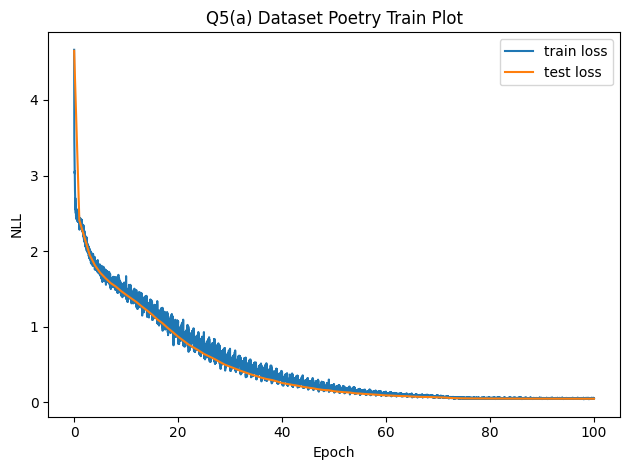

Sample 1
Openly, yes,
         With the naturalness
         Of the hippopotamus or the alligator
When it climbs out on the bank to ex

Sample 2
Our storm is past, and that storm's tyrannous rage,
A stupid calm, but nothing it, doth 'suage.
The fable is inverted, and far

Sample 3
Uper and cast, and aslantial, and a pition of thee.
  now doth thought is it not by strim,
    He more thyseo rem'st mintent, 

Sample 4
Let us go then, you and I,
When the evening is spread out against the sky
Like a patient etherized upon a table;
Let us go, t

Sample 5
Now thou has loved me one whole day,
Tomorrow when you leavst, what wilt thou say?
Wilt thou then antedate some new-made vow?



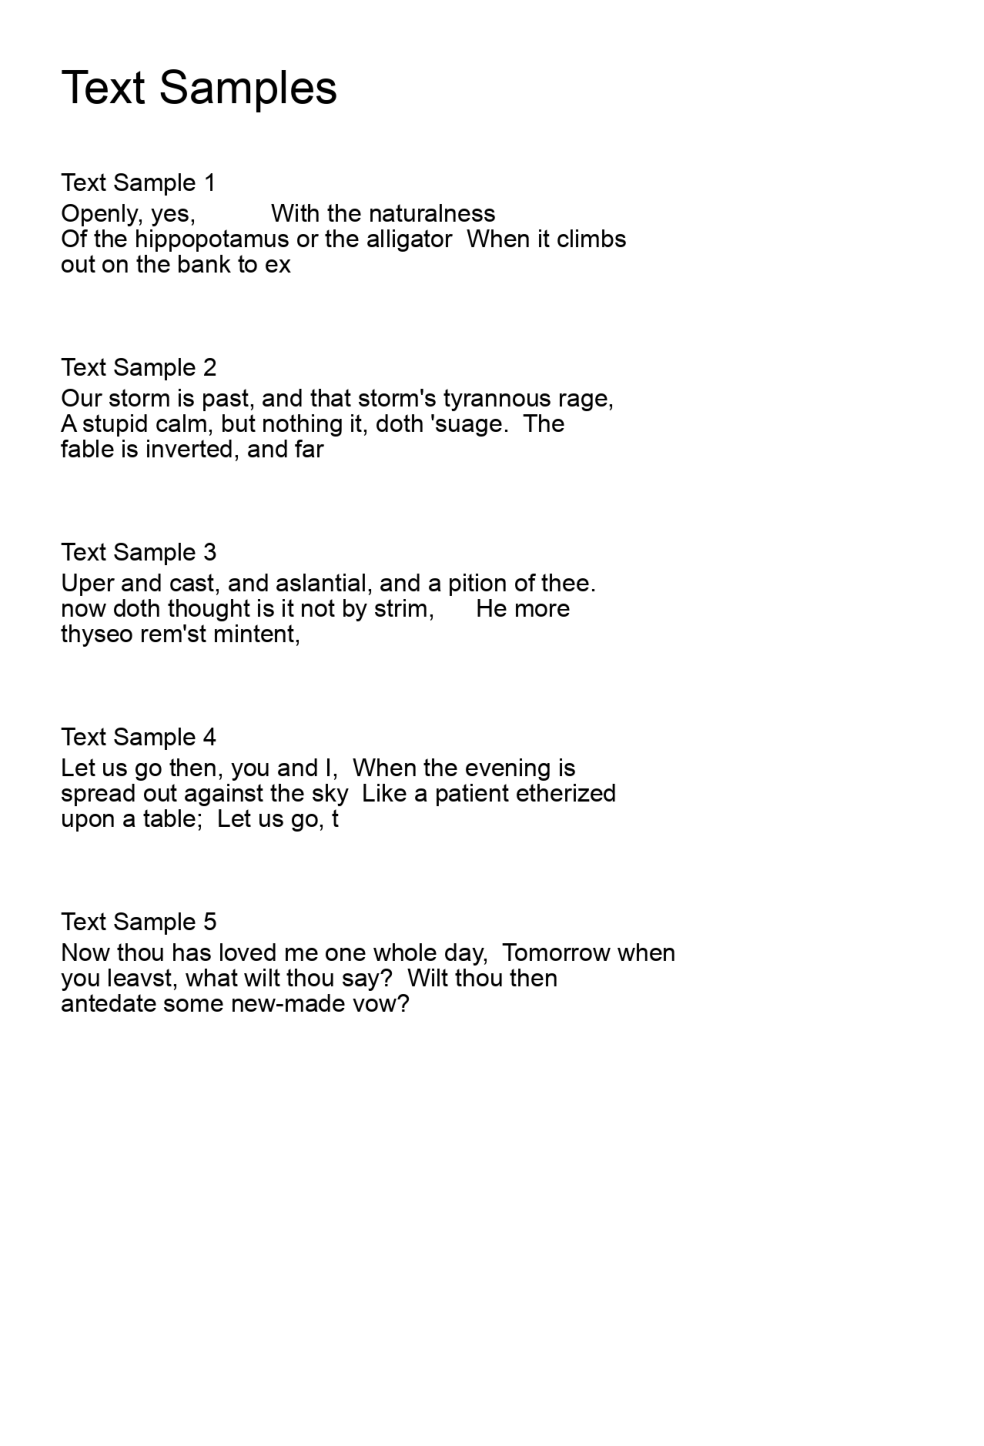

In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

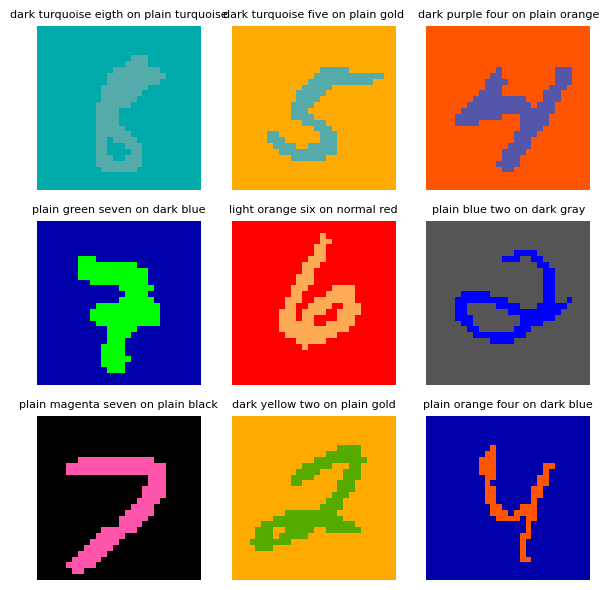

In [ ]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1, attn_mask=None, is_causal=False):
        super().__init__()
        self.key = nn.Linear(d_model, d_model)
        self.query = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)

        self.is_causal = is_causal
        self.attn_mask = attn_mask
        self.num_heads = num_heads
        self.scaling_factor = math.sqrt(d_model / num_heads)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        N, S, D = query.shape
        N, T, D = value.shape
        H = self.num_heads

        # (N, S, D) @ (D, D) -> (N, S, D) -> (N, S, H, D/H) -> (N, H, S, D/H)
        Q = self.query(query).view(N, S, H, D//H).transpose(1, 2)
        # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
        K = self.key(key).view(N, T, H, D//H).transpose(1, 2)
        # (N, T, D) @ (D, D) -> (N, T, D) -> (N, T, H, D/H) -> (N, H, T, D/H)
        V = self.value(value).view(N, T, H, D//H).transpose(1, 2)

        # (N, H, S, D/H) @ (N, H, D/H, T) -> (N, H, S, T)
        Y = torch.matmul(Q, K.transpose(2, 3)) / self.scaling_factor

        if self.is_causal:
            self.attn_mask = torch.tril(torch.ones(S, T))

        # We apply value -inf so that softmax for that element equals 0
        if self.attn_mask is not None:
            Y = Y.masked_fill(self.attn_mask==0, float("-inf"))

        # (N, H, S, T) @ (N, H, T, D/H) -> (N, H, S, D/H)
        Y = self.dropout(F.softmax(Y, dim=-1)) @ V
        # (N, S, H, D/H) -> (N, S, D) @ (D, D) -> (N, S, D)
        out = self.proj(Y.transpose(1, 2).reshape(N, S, D))
        return out


class Block(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.causal_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout, attn_mask=attn_mask, is_causal=is_causal)
        self.msa = lambda x: self.causal_attn(x, x, x)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(nn.Linear(d_model, d_mlp), act, nn.Linear(d_mlp, d_model))

    def forward(self, x):
        x = x + self.msa(self.ln1(x))
        out = x + self.mlp(self.ln2(x))
        return out


class Transformer(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_layers=2, d_model=128, n_heads=4, d_mlp=2048, dropout=0.1, act=nn.GELU(), attn_mask=None, is_causal=True):
        super().__init__()
        self.n_tokens = n_tokens
        self.max_seq_len = max_seq_len

        self.emb = nn.Embedding(n_tokens+1, d_model)
        self.emb.weight.data *= 0.1  # small weight initialization

        self.pos_enc = nn.Parameter(torch.randn(max_seq_len, d_model) * 0.1)

        self.blocks = nn.Sequential(*[
            Block(d_model, n_heads, d_mlp, dropout, act, attn_mask, is_causal) for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_tokens)  # we don't want net to predict <bos>; hence the -1

    def forward(self, x):
        _, seq_len = x.shape

        x = self.emb(x) + self.pos_enc[:seq_len, :] # (N, T, D)
        x = self.blocks(x)
        logits = self.head(self.ln(x))
        return logits

    def loss(self, y):  # (N, T)
        # since autoregressive transformer always predicts the next token for all my NNs,
        # x will get created on the fly by prepending <bos> (token id: 2) and removing the last token in the seq.
        # I could create separate x and y before hand, but this means I can't reuse my train functions

        N, _ = y.shape
        x = torch.cat((torch.tensor(self.n_tokens).expand(N, 1), y[:, :-1]), dim=-1)

        logits = self.forward(x)
        return F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))

In [ ]:
def tokenize_data_set(vqvae, data, H_t=7, W_t=7, bs=16):
    # need to load in batches to avoid cuda out of memory error
    n = data.shape[0]
    assert n % bs == 0
    data_tok = np.zeros((n, H_t*W_t), dtype=int)

    with torch.no_grad():
        for i in range(n // bs):
            data_tok[i*bs:(i+1)*bs] = vqvae.quantize(data[i*bs:(i+1)*bs]).cpu().numpy().reshape(-1, H_t*W_t)  # (n, H, W, C) -> (n_train, 7, 7)

    return data_tok

In [ ]:
from typing import List, Tuple
class Preprocessor:
    def __init__(self, text, vqvae):
        self.vqvae = vqvae
        self.eoi, self.eot = 0, 1
        unique_words = sorted(list(set([word for s in text for word in s.split(' ')])))
        self.wtoi = {w:i+2 for i, w in enumerate(unique_words)}
        self.itow = {v:k for k, v in self.wtoi.items()}

        self.n_text_toks = len(unique_words)
        self.n_img_toks = vqvae.n_embeddings
        self.n_tokens = self.n_text_toks + self.n_img_toks + 2

        self.tok_idx_offset = 2 + len(unique_words)

    def encode_text(self, text: List[str]) -> List[List[int]]:
        return [[self.wtoi[w] for w in s.split(' ')] for s in text]


    def decode_text(self, tokens: List[List[int]]) -> List[str]:
        return [
            ' '.join([self.itow[idx] for idx in seq])
            for seq in tokens
        ]

    def combine(self, img_toks, text_toks):
        p_text_toks = [[self.eoi] + seq for seq in text_toks]
        p_img_toks = np.insert(img_toks + self.tok_idx_offset, 0, self.eot, axis=1)

        split = int(0.5 * len(img_toks))
        text_first = np.hstack([p_text_toks[:split], p_img_toks[:split]])
        img_first = np.hstack([p_img_toks[split:], p_text_toks[split:]])
        return np.vstack([text_first, img_first])


    def decode_multimodal(self, tokens: np.ndarray) -> List[Tuple[np.ndarray, str]]:
        B, _ = tokens.shape
        tok_img_len = 7*7
        text_len = 6

        eoi_mask = tokens[:, 0] == self.eoi
        eot_mask = tokens[:, 0] == self.eot

        tok_imgs = np.vstack([
            tokens[eoi_mask, 8:],
            tokens[eot_mask, 1:tok_img_len+1]
        ]).reshape(-1, 7, 7)

        text_tokens = [
            tokens[i, 1:text_len+1].tolist()
            if eoi_mask[i]
            else tokens[i, 2+tok_img_len:].tolist()
            for i in range(B)
        ]

        tok_imgs = tok_imgs - self.tok_idx_offset

        decoded_imgs = self.vqvae.decode(tok_imgs)
        decoded_text = self.decode_text(text_tokens)

        return [(decoded_imgs[i], decoded_text[i]) for i in range(B)]

In [ ]:
def sample(logits: torch.Tensor, preprocessor, restrict_tokens=None) -> torch.Tensor:
    assert restrict_tokens in (None, 'special', 'text', 'img')
    token_ranges = {
        'special': (0, 2),
        'text': (2, 2 + preprocessor.n_text_toks),
        'img': (2 + preprocessor.n_text_toks, logits.shape[-1])
    }

    start, end = token_ranges.get(restrict_tokens, (0, logits.shape[-1]))
    prob_dist = torch.softmax(logits[:, start:end], dim=-1)
    samples = torch.multinomial(prob_dist, num_samples=1) + start

    return samples


from typing import List
def generate_image(model, text_prompt: List[str], preprocessor):
    x = torch.zeros((len(text_prompt), model.max_seq_len), dtype=torch.long)
    x[:, 0] = model.n_tokens  # add <bos> token
    x[:, 1] = preprocessor.eoi
    len_prompt = len(text_prompt[0].split(' '))

    encoded_text = preprocessor.encode_text(text_prompt)

    x[:, 2:len_prompt+2] = torch.tensor(preprocessor.encode_text(text_prompt))
    x[:, len_prompt+2] = preprocessor.eot

    for i in range(2 + len_prompt, model.max_seq_len):
        logits = model.forward(x)
        samples = sample(logits[:, i, :], preprocessor, restrict_tokens='img')

        if i == model.max_seq_len - 1:
            return torch.cat((x[:, 1:], samples), dim=1)

        x[:, i+1] = samples.view(-1)


def generate_text(model, vqvae, image_prompt: np.ndarray, preprocessor):
    x = torch.zeros((len(image_prompt), model.max_seq_len), dtype=torch.long)
    x[:, 0] = model.n_tokens  # add <bos> token
    x[:, 1] = preprocessor.eot
    tok_img = torch.tensor(vqvae.quantize(image_prompt).reshape(len(image_prompt), -1)) + preprocessor.tok_idx_offset
    img_tok_len = tok_img.shape[1]
    x[:, 2:img_tok_len+2] = tok_img
    x[:, img_tok_len+2] = preprocessor.eoi

    for i in range(2 + img_tok_len, model.max_seq_len):
        logits = model.forward(x)
        samples = sample(logits[:, i, :], preprocessor, restrict_tokens='text')

        if i == model.max_seq_len - 1:
            return torch.cat((x[:, 1:], samples), dim=1)

        x[:, i+1] = samples.view(-1)


# warning: the following is complete spaghetticode.
# A better way to do this is to process the batch simultaneously.
# This can be done by cleverly masking the logits
def generate_unconditional(model, n_samples, preprocessor):
    x = torch.zeros((n_samples, model.max_seq_len), dtype=torch.long)
    x[:, 0] = model.n_tokens  # add <bos> token
    for i in range(n_samples):
        text_token_count, img_token_count = 0, 0
        for j in range(model.max_seq_len):
            logits = model.forward(x[i, :][None, :])
            if j == 0:
                restrict_tokens = 'special'
            elif j == 1:
                restrict_tokens = 'img' if x[i, 1] == preprocessor.eot else 'text'

            samples = sample(logits[:, j, :], preprocessor, restrict_tokens=restrict_tokens)

            if restrict_tokens == 'text':
                text_token_count += 1
                if text_token_count == 7:
                    samples = preprocessor.eot  # force eot token
                    restrict_tokens = 'img'
            elif restrict_tokens == 'img':
                img_token_count += 1
                if img_token_count == 50:
                    samples = preprocessor.eoi  # force eoi otken
                    restrict_tokens = 'text'

            if j == model.max_seq_len - 1:
                x[i] = torch.cat((x[i, 1:][None, :], samples), dim=1)
                break

            x[i, j+1] = samples
    return x

In [ ]:
class CosineScheduler:
    def __init__(self, warmup_iters, lr_decay_iters, base_lr, min_lr):
        self.warmup_iters = warmup_iters
        self.lr_decay_iters = lr_decay_iters
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.iter = 0
    def step(self):
        if self.iter < self.warmup_iters:
            lr = self.base_lr * self.iter / self.warmup_iters
        else:
            iter = self.iter - self.warmup_iters
            lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) \
                * (1 + math.cos(math.pi * iter / self.lr_decay_iters))
        self.iter += 1
        return lr

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """

  # preprocessing
  train_data_toks, test_data_toks = tokenize_data_set(vqvae, train_data), tokenize_data_set(vqvae, test_data)

  preprocessor = Preprocessor(train_text, vqvae)
  train_text_toks, test_text_toks = preprocessor.encode_text(train_text), preprocessor.encode_text(test_text)

  train_set, test_set = preprocessor.combine(train_data_toks, train_text_toks), preprocessor.combine(test_data_toks, test_text_toks)

  hyp = dict(
    lr=1e-3,
    epochs=10,
    batch_size=32,
    warmup_iters=0,
    min_lr=1e-4,
    dropout=0.0,
    context_size=128
  )

  hyp['lr_decay_iters'] = (len(train_set) // hyp['batch_size']) * hyp['epochs'] - hyp['warmup_iters']

  lr_scheduler = CosineScheduler(warmup_iters=hyp['warmup_iters'], lr_decay_iters=hyp['lr_decay_iters'],
                                 base_lr=hyp['lr'], min_lr=hyp['min_lr'])

  model = Transformer(n_tokens=preprocessor.n_tokens, max_seq_len=57, n_heads=4, n_layers=2, d_model=128, dropout=hyp['dropout'])
#   model = Transformer(n_tokens=preprocessor.n_tokens, max_seq_len=57, n_heads=2, n_layers=1, d_model=16, dropout=hyp['dropout'])

  optimizer = optim.Adam(model.parameters(), lr=hyp['lr'])

  train_loader, test_loader = create_dataloaders(train_set, test_set, hyp['batch_size'])

  train_loss_history, test_loss_history = train(model, optimizer, train_loader, test_loader, num_epochs=hyp['epochs'],
                                                lr_scheduler=lr_scheduler, clip=1.0)


  samples_text_conditioned = preprocessor.decode_multimodal(generate_image(model, text_test_prompt, preprocessor).cpu().numpy())
  samples_image_conditioned = preprocessor.decode_multimodal(generate_text(model, vqvae, image_test_prompt, preprocessor).cpu().numpy())
  samples_unconditioned = preprocessor.decode_multimodal(generate_unconditional(model, 9, preprocessor).cpu().numpy())

  return np.array(train_loss_history), np.array(test_loss_history), samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



initial loss: 7.127212973829275
epoch 1: 3.0190821889871224
epoch 2: 2.8359209531412337
epoch 3: 2.7516112502771444
epoch 4: 2.696060278164312
epoch 5: 2.657863577333883
epoch 6: 2.6272585544342433
epoch 7: 2.6106305815541324
epoch 8: 2.5999641334667754
epoch 9: 2.597510129118118
epoch 10: 2.597267463184393


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Final Test Loss: 2.5973


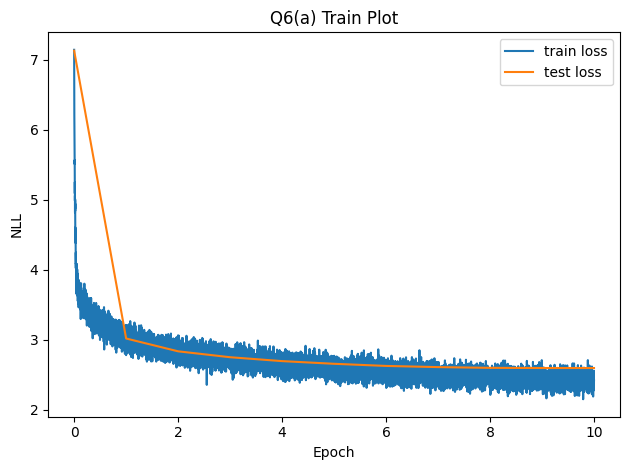

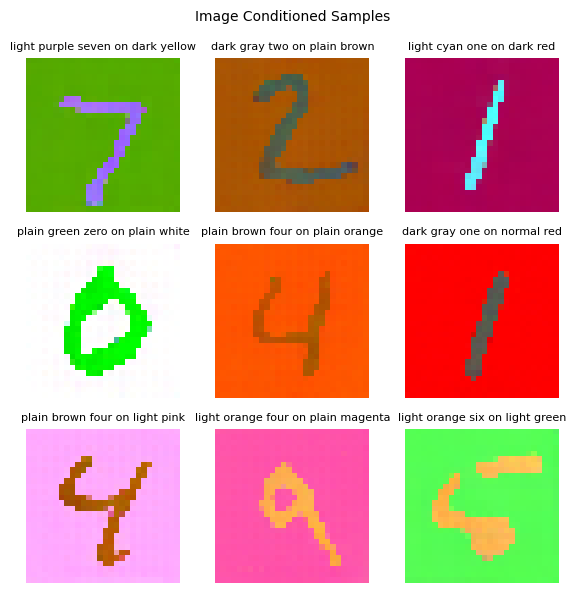

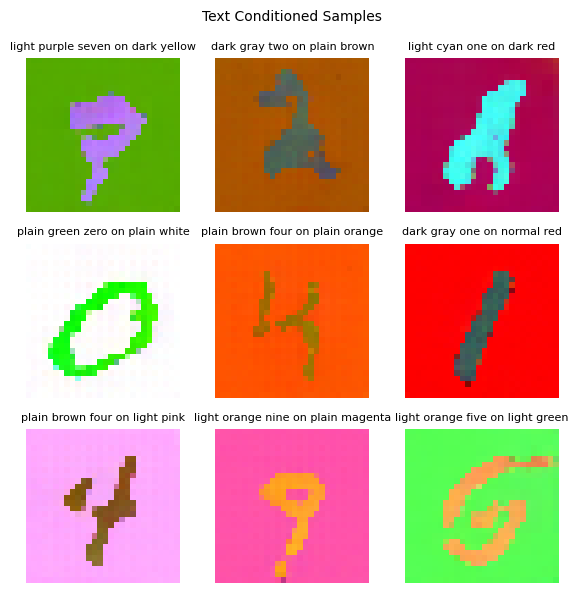

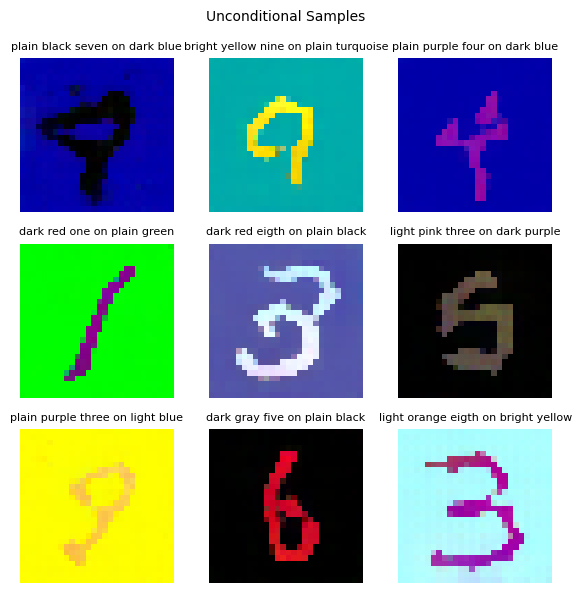

In [ ]:
q6a_save_results(q6_a)